# Importovanje

In [139]:
!pip install pycuda

In [140]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl

# Kerneli

In [145]:
kernel_code = r"""
__global__ void diffusion_step_kernel(
    const float* conc, float* conc_out,
    int H, int W,
    float decay
){
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= W || y >= H) return;

    int idx = y * W + x;

    float center = conc[idx];
    float up    = (y > 0)     ? conc[(y - 1) * W + x] : 0.0f;
    float down  = (y < H - 1) ? conc[(y + 1) * W + x] : 0.0f;
    float left  = (x > 0)     ? conc[y * W + (x - 1)] : 0.0f;
    float right = (x < W - 1) ? conc[y * W + (x + 1)] : 0.0f;

    float avg = (center + up + down + left + right) / 5.0f;
    avg *= (1.0f - decay);
    conc_out[idx] = avg;
}

__global__ void apply_sources_kernel(
    float* conc,
    const unsigned char* cell_type,
    int H, int W,
    float source_value,
    float absorb_value
){
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= W || y >= H) return;

    int idx = y * W + x;

    if (cell_type[idx] == 1) {
        conc[idx] = source_value;
    }
    else if (cell_type[idx] == 2) {
        float v = conc[idx] - absorb_value;
        conc[idx] = (v > 0.0f) ? v : 0.0f;
    }
}

__global__ void count_danger_kernel(
    const float* conc,
    int* danger_count,
    int H, int W,
    float danger_threshold
){
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= W || y >= H) return;

    int idx = y * W + x;

    if (conc[idx] >= danger_threshold)
        danger_count[idx] += 1;
}

__global__ void count_ever_dangerous_kernel(
    const int* danger_count,
    int H, int W,
    int* danger_counter
){
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= W || y >= H) return;

    int idx = y * W + x;

    if (danger_count[idx] > 0)
        atomicAdd(danger_counter, 1);
}

__global__ void region_hotspot_stats_kernel(
    const int* danger_steps, unsigned char* is_hotspot, // H x W
    float* region_means,  // num_regions
    int H, int W,
    int R, int C,
    float alpha
){
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    int region_x = blockIdx.x;
    int region_y = blockIdx.y;

    int global_x = region_x * C + tx;
    int global_y = region_y * R + ty;

    int local_idx = ty * C + tx;
    int region_size = R * C;

    // ========================================================================
    // deljena memorija
    extern __shared__ unsigned char smem[];

    int* sh_danger = (int*)smem;
    float* sh_reduce = (float*)(sh_danger + region_size);
    float* sh_mean = sh_reduce + region_size;
    float* sh_std  = sh_mean + 1;

    int gidx = global_y * W + global_x;
    sh_danger[local_idx] = danger_steps[gidx];

    __syncthreads();

    // srednja vrednost
    // ========================================================================
    sh_reduce[local_idx] = (float)sh_danger[local_idx];
    __syncthreads();

    for (int stride = region_size / 2; stride > 0; stride >>= 1) {
        if (local_idx < stride)
            sh_reduce[local_idx] += sh_reduce[local_idx + stride];
        __syncthreads();
    }

    if (local_idx == 0) {
        *sh_mean = sh_reduce[0] / region_size;
        int region_id = region_y * (W / C) + region_x;
        region_means[region_id] = *sh_mean;
    }
    __syncthreads();

    // standardna devijacija
    // ========================================================================
    float diff = (float)sh_danger[local_idx] - (*sh_mean);
    sh_reduce[local_idx] = diff * diff;
    __syncthreads();

    for (int stride = region_size / 2; stride > 0; stride >>= 1) {
        if (local_idx < stride)
            sh_reduce[local_idx] += sh_reduce[local_idx + stride];
        __syncthreads();
    }

    if (local_idx == 0)
        *sh_std = sqrtf(sh_reduce[0] / region_size);

    __syncthreads();

    // zariste
    // ========================================================================
    float threshold = (*sh_mean) + alpha * (*sh_std);
    is_hotspot[gidx] = (sh_danger[local_idx] > threshold) ? 1 : 0;
}
"""
mod = SourceModule(kernel_code)
diffusion_kernel = mod.get_function("diffusion_step_kernel")
apply_kernel = mod.get_function("apply_sources_kernel")
danger_kernel = mod.get_function("count_danger_kernel")
count_dangerous_kernel = mod.get_function("count_ever_dangerous_kernel")
region_kernel = mod.get_function("region_hotspot_stats_kernel")

# Alociranje i deklaracije

In [146]:
def run_simulation(H, W, T, R, C, # H = visina matrice (y), W = sirina matrice (x), T = vreme trajanja simulacije
                   decay=0.01, source_value=1.0,
                   absorb_value=0.05, danger_threshold=0.3,
                   alpha=1.0): # R = visina regiona (y), C = sirina regiona (x)
    assert H % R == 0 and W % C == 0
    num_regions_x = W // C
    num_regions_y = H // R
    num_regions = num_regions_x * num_regions_y
    #inicijalizovanje matrica
    #==========================================================================
    conc = np.zeros((H, W), dtype=np.float32)
    conc_next = np.zeros_like(conc)
    cell_type = np.zeros((H, W), dtype=np.uint8)
    danger_count = np.zeros((H, W), dtype=np.int32)
    is_hotspot = np.zeros((H, W), dtype=np.uint8)
    region_means = np.zeros(num_regions, dtype=np.float32)

    #primer izvora i cistaca, izvor = 1, cistac = 2
    cell_type[H//4, W//4] = 1
    cell_type[8,8] = 1
    cell_type[6,2] = 1
    cell_type[8,7] = 2
    cell_type[3*H//4, 3*W//4] = 2

    #pisanje na gpu
    #==========================================================================
    conc_gpu = cuda.mem_alloc(conc.nbytes)
    conc_next_gpu = cuda.mem_alloc(conc.nbytes)
    cell_type_gpu = cuda.mem_alloc(cell_type.nbytes)
    danger_count_gpu = cuda.mem_alloc(danger_count.nbytes)
    is_hotspot_gpu = cuda.mem_alloc(is_hotspot.nbytes)
    region_means_gpu = cuda.mem_alloc(region_means.nbytes)

    cuda.memcpy_htod(conc_gpu, conc)
    cuda.memcpy_htod(cell_type_gpu, cell_type)
    cuda.memcpy_htod(danger_count_gpu, danger_count)
    cuda.memcpy_htod(is_hotspot_gpu, is_hotspot)

    #pokretanje simulacije
    #==========================================================================
    block = (16, 16, 1)
    grid = ((W + 15) // 16, (H + 15) // 16)

    start = time.time()

    for _ in range(T):
        #difuzija + raspadanje
        diffusion_kernel(
            conc_gpu,
            conc_next_gpu,
            np.int32(H),
            np.int32(W),
            np.float32(decay),
            block=block,
            grid=grid
        )

        #izvori i cistaci
        apply_kernel(
            conc_next_gpu,
            cell_type_gpu,
            np.int32(H),
            np.int32(W),
            np.float32(source_value),
            np.float32(absorb_value),
            block=block,
            grid=grid
        )
        danger_kernel(
            conc_next_gpu, danger_count_gpu,
            np.int32(H), np.int32(W),
            np.float32(danger_threshold),
            block=block, grid=grid
        )

        #swap buffera
        conc_gpu, conc_next_gpu = conc_next_gpu, conc_gpu

    cuda.Context.synchronize()
    elapsed = time.time() - start

    #brojanje svih opasnih celija
    #==========================================================================
    danger_counter = np.zeros(1, dtype=np.int32)
    danger_counter_gpu = cuda.mem_alloc(danger_counter.nbytes)
    cuda.memcpy_htod(danger_counter_gpu, danger_counter)

    count_dangerous_kernel(
        danger_count_gpu,
        np.int32(H), np.int32(W),
        danger_counter_gpu,
        block=block, grid=grid
    )

    #analiza regiona i zarista
    #==========================================================================
    region_block = (C, R, 1)
    region_grid = (num_regions_x, num_regions_y, 1)

    shared_bytes = (
        R * C * 4 +   # danger_steps (int)
        R * C * 4 +   # reduction buffer (float)
        2 * 4         # mean + std
    )

    region_kernel(
        danger_count_gpu,
        is_hotspot_gpu,
        region_means_gpu,
        np.int32(H), np.int32(W),
        np.int32(R), np.int32(C),
        np.float32(alpha),
        block=region_block,
        grid=region_grid,
        shared=shared_bytes
    )
    #izlaz
    #==========================================================================
    cuda.memcpy_dtoh(danger_counter, danger_counter_gpu)
    cuda.memcpy_dtoh(danger_count, danger_count_gpu)
    cuda.memcpy_dtoh(conc, conc_gpu)
    cuda.memcpy_dtoh(is_hotspot, is_hotspot_gpu)
    cuda.memcpy_dtoh(region_means, region_means_gpu)
    return conc, elapsed, danger_count, danger_counter[0], is_hotspot, region_means


# Main

In [147]:
tests = [
        (10, 10),
        (100, 100),
        (1000, 1000),
    ]
T = 100
region_data =np.empty((5,5), dtype = float)

danger_matrices = [np.empty(shape) for shape in tests]
i = 0
for H, W in tests:
    conc, t, total_danger, dc, hotspots, region_means = run_simulation(H, W, T,R=2, C=2)
    if(H == 10 and W == 10):
      region_data = region_means.reshape(5,5)
    danger_matrices[i] = total_danger
    i+=1
    print(f"Mreža {H}x{W}, T={T} → vreme: {t:.4f} s, ukupne opasne: {dc}, \n nivoi opasnoti po mestima:\n{total_danger}, \n{hotspots}\nsrednje vrednosti regiona: \n{region_means},")

Mreža 10x10, T=100 → vreme: 0.0041 s, ukupne opasne: 30, 
 nivoi opasnoti po mestima:
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0  96  76   0   0   0   0   0   0]
 [  0  96 100  96  57   0   0   0   0   0]
 [  0  87  96  88  63   0   0   0   0   0]
 [  0  81  90  84  64   0   0   0   0   0]
 [  0  87  96  88  69   0   0   0   0   0]
 [  0  96 100  96  72   0   0   0   0   0]
 [  0  74  96  82   0   0   0   0  95   0]
 [  0   0   0   0   0   0   0  83 100  95]
 [  0   0   0   0   0   0   0   0  95   0]], 
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
srednje vrednosti regiona: 
[ 0.   43.    0.    0.    0.   45.75 95.   30.    0.    0.   42.   89.5
 33.25  0.    0.   42.5  93.5  18.    0.   23.75  0.    0.    0.   20.75
 72.5 ],
Mreža 100x100, T=100 → vreme: 0.0066 s, ukupne opasne: 45, 
 nivoi o

# Vizuelizacija

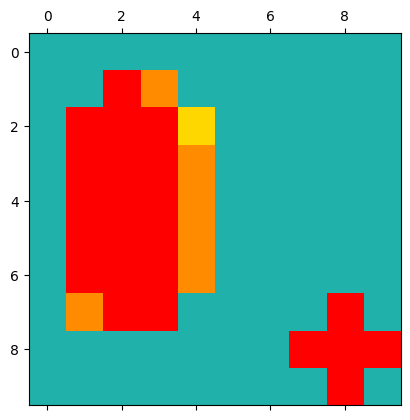

[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0  96  76   0   0   0   0   0   0]
 [  0  96 100  96  57   0   0   0   0   0]
 [  0  87  96  88  63   0   0   0   0   0]
 [  0  81  90  84  64   0   0   0   0   0]
 [  0  87  96  88  69   0   0   0   0   0]
 [  0  96 100  96  72   0   0   0   0   0]
 [  0  74  96  82   0   0   0   0  95   0]
 [  0   0   0   0   0   0   0  83 100  95]
 [  0   0   0   0   0   0   0   0  95   0]]


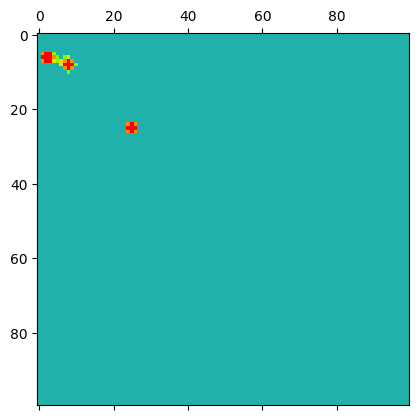

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


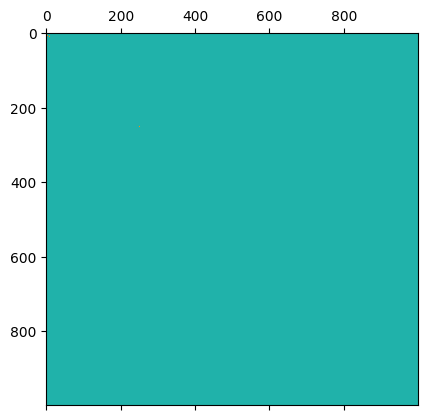

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [148]:
cmap = mpl.colors.ListedColormap(["lightseagreen", "lawngreen", "gold", "darkorange", "red"])
for m in danger_matrices:
  plt.matshow(m, cmap = cmap)
  plt.show()
  print(m)

Vizuelizacija po regionima

//odabrana je samo prva matrica za ovu vizuelizaciju zato sto ona izgleda najbolje

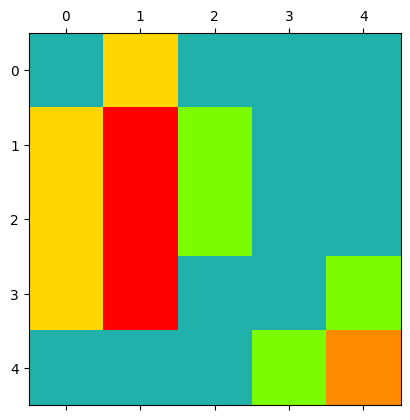

[[ 0.   43.    0.    0.    0.  ]
 [45.75 95.   30.    0.    0.  ]
 [42.   89.5  33.25  0.    0.  ]
 [42.5  93.5  18.    0.   23.75]
 [ 0.    0.    0.   20.75 72.5 ]]


In [149]:
cmap = mpl.colors.ListedColormap(["lightseagreen", "lawngreen", "gold", "darkorange", "red"])
plt.matshow(region_data, cmap = cmap)
plt.show()
print(region_data)